In [1]:
import pandas as pd
import os
import gensim

## Data Pre-Processing

In [2]:
abcnews = pd.read_csv("abcnews-date-text.csv")
abcnews.head(5)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [3]:
"""apply preprocess function to dataset
observe the 3rd row to see the differences (ex. "a" and "g" are removed)
"""

def preprocess_data(input_text: str):
    final_text = list()
    for token in gensim.utils.simple_preprocess(input_text):
        if len(token) >= 3 and token not in gensim.parsing.preprocessing.STOPWORDS:
            final_text.append(token)
    return final_text

abc_docs = abcnews["headline_text"].map(preprocess_data)
abc_docs.head(5)

0    [aba, decides, community, broadcasting, licence]
1                 [act, witnesses, aware, defamation]
2         [calls, infrastructure, protection, summit]
3               [air, staff, aust, strike, pay, rise]
4       [air, strike, affect, australian, travellers]
Name: headline_text, dtype: object

In [4]:
abc_dict = gensim.corpora.Dictionary(abc_docs)
count = 0
for index, token in abc_dict.iteritems():
    count += 1
    if count > 10:
        break
    print(index, token)

0 aba
1 broadcasting
2 community
3 decides
4 licence
5 act
6 aware
7 defamation
8 witnesses
9 calls


In [5]:
#removing too infrequent and too frequent words (irrelevant to topics but too common also reduces meaning)
abc_dict.filter_extremes(no_below=10, no_above=0.5)

In [6]:
#convert into each document into bag of words
bow_corpus = [abc_dict.doc2bow(doc) for doc in abc_docs]

#TF-IDF conversion
abc_tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = abc_tfidf[bow_corpus]

### Training LDA on 1M ABC Headlines

In [7]:
#enable logging of perplexity for convergence
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

In [8]:
#Train LDA on 1M dataset and output 10 topics
abc_lda_model = gensim.models.LdaMulticore(
    corpus_tfidf, 
    num_topics=10, 
    id2word=abc_dict, 
    eval_every=100,
    passes=40, #num epochs
    workers=None)

abc_lda_model.print_topics(-1)

[(0,
  '0.009*"country" + 0.009*"interview" + 0.008*"cup" + 0.008*"world" + 0.008*"hour" + 0.007*"australia" + 0.007*"win" + 0.007*"final" + 0.006*"afl" + 0.006*"league"'),
 (1,
  '0.007*"nrl" + 0.005*"coal" + 0.005*"joe" + 0.005*"black" + 0.004*"marriage" + 0.004*"new" + 0.004*"festival" + 0.004*"chris" + 0.004*"kimberley" + 0.004*"morning"'),
 (2,
  '0.008*"market" + 0.006*"australian" + 0.006*"rise" + 0.006*"prices" + 0.005*"wall" + 0.005*"coronavirus" + 0.005*"new" + 0.005*"october" + 0.004*"share" + 0.004*"rates"'),
 (3,
  '0.009*"government" + 0.007*"coronavirus" + 0.006*"federal" + 0.005*"restrictions" + 0.005*"live" + 0.005*"new" + 0.005*"council" + 0.005*"nsw" + 0.005*"morrison" + 0.005*"funding"'),
 (4,
  '0.016*"news" + 0.014*"rural" + 0.009*"markets" + 0.008*"queensland" + 0.007*"nsw" + 0.007*"national" + 0.007*"abc" + 0.007*"north" + 0.006*"east" + 0.006*"business"'),
 (5,
  '0.009*"health" + 0.007*"royal" + 0.007*"vaccine" + 0.007*"care" + 0.007*"commission" + 0.006*"coro

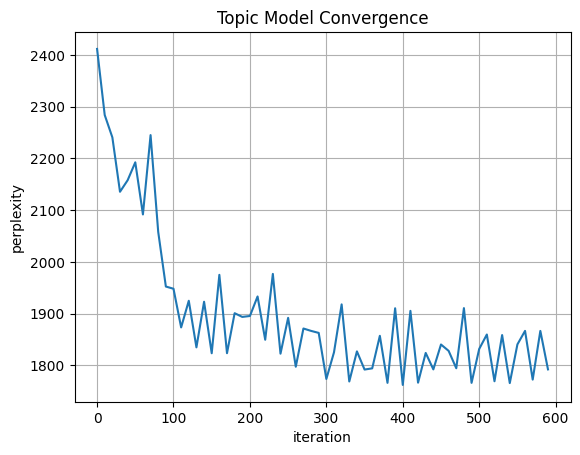

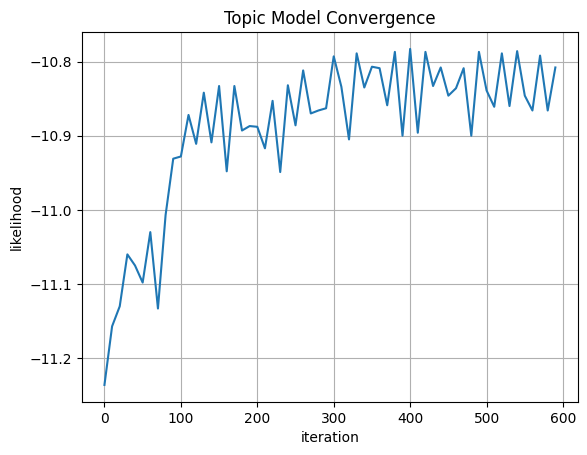

<Figure size 640x480 with 0 Axes>

In [9]:
#plot likelihood and perplexity
import re
import matplotlib.pyplot as plt

p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]

perplexity = [float(t[1]) for t in tuples]
likelihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))

metrics = {
    "perplexity": perplexity,
    "likelihood": likelihood
}

for title in metrics.keys():
    plt.plot(iter, metrics[title])
    plt.ylabel("{}".format(title))
    plt.xlabel("iteration")
    plt.title("Topic Model Convergence")
    plt.grid()
    # plt.savefig("convergence_liklihood.pdf")
    # plt.close()
    plt.figure()

In [10]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(abc_lda_model, corpus_tfidf, abc_dict)

/Users/seichang/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/seichang/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/seichang/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/seichang/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/seichang/miniconda3/lib/python3.9/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.167272 -0.121583       1        1  13.540824
0     -0.029165  0.368711       2        1  11.417913
6     -0.035980  0.050574       3        1  10.234578
2     -0.149560 -0.061273       4        1   9.994131
8      0.263481 -0.031169       5        1   9.927520
9      0.224030 -0.043631       6        1   9.858085
5     -0.114273 -0.148046       7        1   9.792517
4     -0.108870 -0.037679       8        1   9.034212
7      0.198270 -0.064595       9        1   8.327353
1     -0.080661  0.088692      10        1   7.872867, topic_info=            Term         Freq        Total Category  logprob  loglift
16799      trump  4497.000000  4497.000000  Default  30.0000  30.0000
315          man  7511.000000  7511.000000  Default  29.0000  29.0000
1548        news  4581.000000  4581.000000  Default  28.0000  28.0000
213        crash  3433.000000  3433.000000  Default  27.0000  27.0000
1544       rural  4123.000000  4123.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1998       party   573.809387  1590.973676  Topic10  -5.9029   1.5219
1144    election   598.106474  4207.725866  Topic10  -5.8614   0.5908
40     australia   609.488159  8230.117884  Topic10  -5.8426  -0.0612
1347       years   547.151612  2929.435953  Topic10  -5.9505   0.8639
453         says   551.395136  7044.916460  Topic10  -5.9427  -0.0059

[540 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
3393       1  0.781467  abbott
3393       3  0.115528  abbott
3393      10  0.102325  abbott
6333       2  0.191706     abc
6333       7  0.267850     abc
...      ...       ...     ...
123        1  0.116862   youth
123        4  0.089827   youth
123        5  0.093315   youth
123        7  0.700298   youth
11688      4  0.997188    zero

[1096 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 3, 9, 10, 6, 5, 8, 2])